# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$.

Reproduce the results in *Barthel et. al*, [Matrix product algorithm for stochastic dynamics on networks applied to nonequilibrium Glauber dynamics](https://doi.org/10.1103/PhysRevE.97.010104) for $k=3$.

In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MatrixProductBP`


In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [12]:
q = q_glauber   # number of states is 2 for spin variables
T = 50          # final time
k = 3           # degree
m⁰ = 0.5;     # magnetization at time zero

In [13]:
svd_trunc = TruncBond(10)
maxiter = 100
tol = 1e-3
A, iters, Δs, b = glauber_infinite_graph(T, k, m⁰; svd_trunc, maxiter, tol);

Iterating BP on infinite graph  41%|████████▋            |  ETA: 0:22:52
  iter:  41/100
  Δ:     0.0/0.001

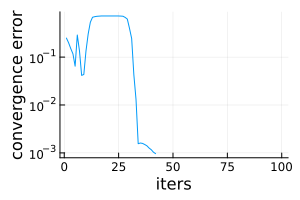

In [14]:
plot(Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="")

In [15]:
magnetiz = [bb[1] - bb[2] for bb in b];

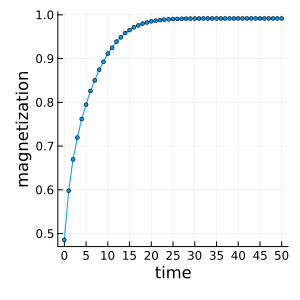

In [16]:
plot(0:T, magnetiz, m=:o, xlabel="time", ylabel="magnetization", label="",
    size=(300,300), xticks=0:5:T, ms=2)

Compare with:

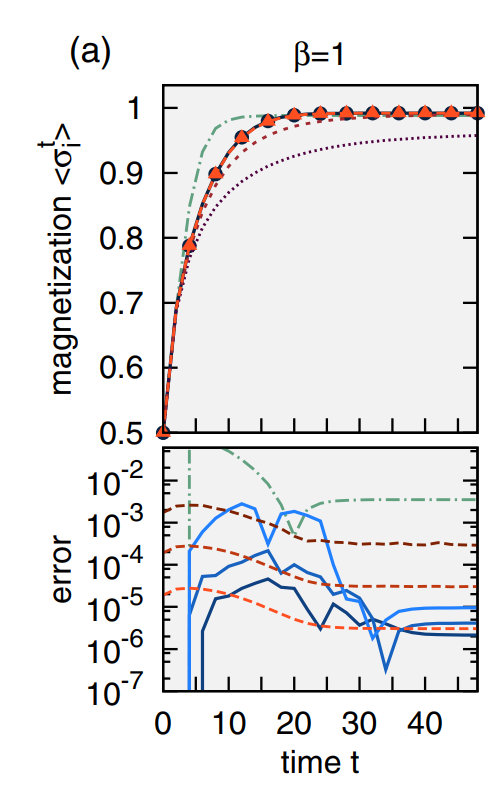